Se importan los modulos necesarios para la implementacion del modelo, es esta oportunidad se realizará con el modelo DecisionTreeClassifier.

In [1]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

Se crea una funcion que transforma y estandariza los valores. En funcion de los parametros, puede retornar un dataframe transformado o cuatro (4) dataframes para entrenar y testear el modelo. 

In [2]:
def transform(df, to_le=[], to_ss=[], to_tts=[], ros=False, test_size=False, random_state=False):
    '''
    La siguiente función recibe como parametro un dataframe con el que se entrenará el modelo; transforma el dataframe entrante y retorna
    en funcion de los parametros un dataframe solo con las columnas a tranformar ó dataframes para ser unados en el entrenamito y testeo del modelo.
    

    Descripción de los parametros.

    df: Dataframe a transformar
    to_le: Lista de columnas categoricas para realizarles LabelEncoder.
    to_ss: Lista de columnas numericas para realizarles StandardScaler.
    to_tts: Columna target en formato lista. Si este parametro no es pasado, retorna un datraframe con los cambios realizados anteriormente,
        caso contrario, retorna dataframes para pruebas y testeos.

    Solo si 'to_tts' es pasado como parametro.
    
    ros: True si se cuenta con un conjunto de datos desbalanceado y se necesita realizar RandomOverSampler.
    test_size: Porción del dataframe que se reservara para los testeos. Parametro propio de la función train_test_split.
    random_state: Maneja el estado de aletoriedad en la que se separan los dataframes. Parametro propio de la función train_test_split.
    '''

    # Iteramos por las columnas pasadas como parametros y realizamos cambios.
    if to_le:
        for i in df[to_le]:
            df[i] = LabelEncoder().fit_transform(df[i].values)

    if to_ss:
        for i in df[to_ss]:
            df[i] = StandardScaler().fit_transform(df[[i]].values)

    # Separamos el target. Cero (0) para estadias cortas (0-8 días) y Uno (1) para estadias largas (9 en adelante).
    if to_tts:
        df[to_tts] = df[to_tts].mask(df[to_tts] <= 8, 0)
        df[to_tts] = df[to_tts].mask(df[to_tts] > 8, 1)

        # Creamos un dataframe con las columnas transformadas y eliminamos las duplicadas.
        df_aux = df[to_le + to_ss + to_tts].copy()
        df_aux.drop_duplicates(inplace=True)

        # Separamos los features (X) y el target (y).
        y = df_aux[to_tts]
        X = df_aux.drop(to_tts, axis=1)

        if ros:
            # Equilibra 50-50 en funcion del target.
            ros = RandomOverSampler(sampling_strategy=1)
            X, y = ros.fit_resample(X, y)

        # Se divide el dataframe segun la porción pasada en test_size.
        X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Retornamos las divisiones.
        return X_Train, X_Test, Y_Train, Y_Test

    else:
        # Retornamos un dataframe con las columnas transformadas.
        df_aux = df[to_le + to_ss].copy()

        return df_aux

Se define una función para graficar un heatmap de correlación.

In [3]:
def plot_corre_heatmap(corr):
    '''
    Recibe como parametro un dataframe de correlaciones entre las columnas.
    '''
    
    plt.figure(figsize=(16,14))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f',annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)

    # Se arregla un problema de visualización
    b, t = plt.ylim() # Muestra los valores
    b += 0.5 # Se agrega 0.5 al bottom
    t -= 0.5 # Se resta 0.5 del top
    plt.ylim(b, t) # Se actualiza el valor del ylim(bottom, top)
    plt.show()

Se inicia la transformación, entrenamiento y testeo del modelo.

In [4]:
# Se guardam el dataframe a una variable.

data = pd.read_csv('./datasets/hospitalizaciones_train.csv')

In [5]:
# Se evalúa la cantidad de registros, los tipos de datos y valores nulos.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410000 entries, 0 to 409999
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Available Extra Rooms in Hospital  410000 non-null  int64  
 1   Department                         410000 non-null  object 
 2   Ward_Facility_Code                 410000 non-null  object 
 3   doctor_name                        410000 non-null  object 
 4   staff_available                    410000 non-null  int64  
 5   patientid                          410000 non-null  int64  
 6   Age                                410000 non-null  object 
 7   gender                             410000 non-null  object 
 8   Type of Admission                  410000 non-null  object 
 9   Severity of Illness                410000 non-null  object 
 10  health_conditions                  410000 non-null  object 
 11  Visitors with Patient              4100

In [6]:
# Se evalúa si las columnas son de tipo categoricas o almacenan valores numéricos.

data.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,4,gynecology,D,Dr Sophia,0,33070,41-50,Female,Trauma,Extreme,Diabetes,4,Yes,2966.408696,8
1,4,gynecology,B,Dr Sophia,2,34808,31-40,Female,Trauma,Minor,Heart disease,2,No,3554.835677,9
2,2,gynecology,B,Dr Sophia,8,44577,21-30,Female,Trauma,Extreme,Diabetes,2,Yes,5624.733654,7
3,4,gynecology,D,Dr Olivia,7,3695,31-40,Female,Urgent,Moderate,None,4,No,4814.149231,8
4,2,anesthesia,E,Dr Mark,10,108956,71-80,Male,Trauma,Moderate,Diabetes,2,No,5169.269637,34


In [7]:
# Determinamos la clasificacion de las columnas y realizamos las transformaciones. 
# Para efectos practicos se crean de una vez las variables de prueba y testeo segun las columnas pasadas, en otras palabras,
# las columnas que se asignan como parametros, seran las usadas en el modelo.

categorica = ['Department', 'Ward_Facility_Code', 'doctor_name', 'Age', 'gender', 'Type of Admission', 'Severity of Illness',
        'health_conditions', 'Insurance']

numerica = ['Available Extra Rooms in Hospital', 'staff_available', 'Visitors with Patient', 'Admission_Deposit']

target = ['Stay (in days)']

X_Train, X_Test, Y_Train, Y_Test = transform(data, to_le=categorica, to_ss=numerica, to_tts=target, ros=False, test_size=0.2, random_state=42)

In [8]:
# Se evalúan los cambios.

data.head()

,Available Extra Rooms in Hospital,Department,Ward_Facility_Code,doctor_name,staff_available,patientid,Age,gender,Type of Admission,Severity of Illness,health_conditions,Visitors with Patient,Insurance,Admission_Deposit,Stay (in days)
0,0.133481,2,3,8,-1.589906,33070,4,0,1,0,1,0.199105,1,-1.677467,0
1,0.133481,2,1,8,-0.956597,34808,3,0,1,1,2,-0.690790,0,-1.115679,1
2,-0.606794,2,1,8,0.943331,44577,2,0,1,0,1,-0.690790,1,0.860510,0
3,0.133481,2,3,4,0.626677,3695,3,0,2,2,4,0.199105,0,0.086622,0
4,-0.606794,1,4,2,1.576641,108956,7,1,1,2,1,-0.690790,0,0.425666,1


Se evalúa el balanceo de los datos en relación al target. Si el desbalanceo es menor a 0.60 se procede a cambiar el parametro 'ros=True' en la función 'transform'. 

In [9]:
Y_Train.value_counts()[0]/Y_Train.value_counts()[1], Y_Test.value_counts()[0]/Y_Test.value_counts()[1]

(0.6044847304905908, 0.6081900017650866)

Se evalúa la correlatividad entre las columnas para definir las más apropiadas.

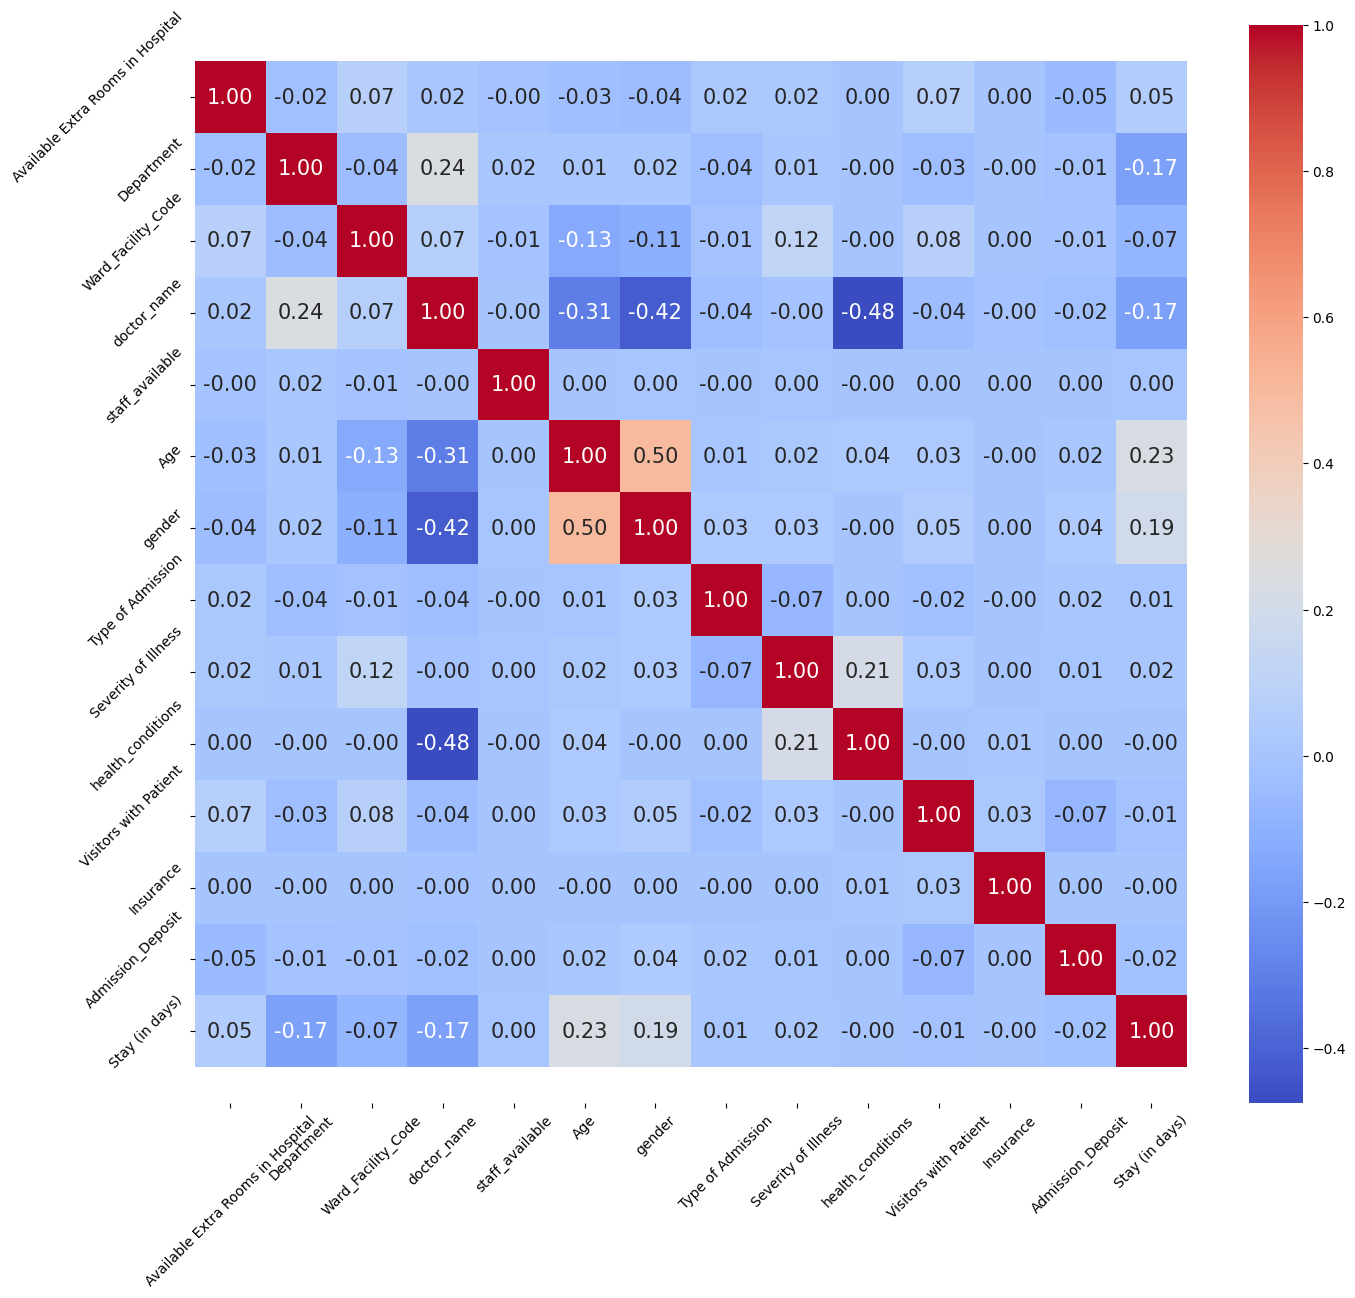

In [10]:
# De ser necesario un cambio entre las features de selección, se retrocedería un paso atras y se reasignaría los parametros en la función 'transform'.

# Al realizar varios experimentos, no observar fuerte correlatividad entre las features y determinar que una cierta selección de columnas (segun criterio
# personal de ser las más relativas) no arroja valoraciones importantes, se decide entrenar el modelo con todas las columnas a excepcion del 'patientid'
# que en terminos generales es irrelevante.

data.drop('patientid', axis=1, inplace=True)
corr = data.corr()
plot_corre_heatmap(corr)

Se evalúa que profundidad es la más optima para el entrenamiento del modelo.

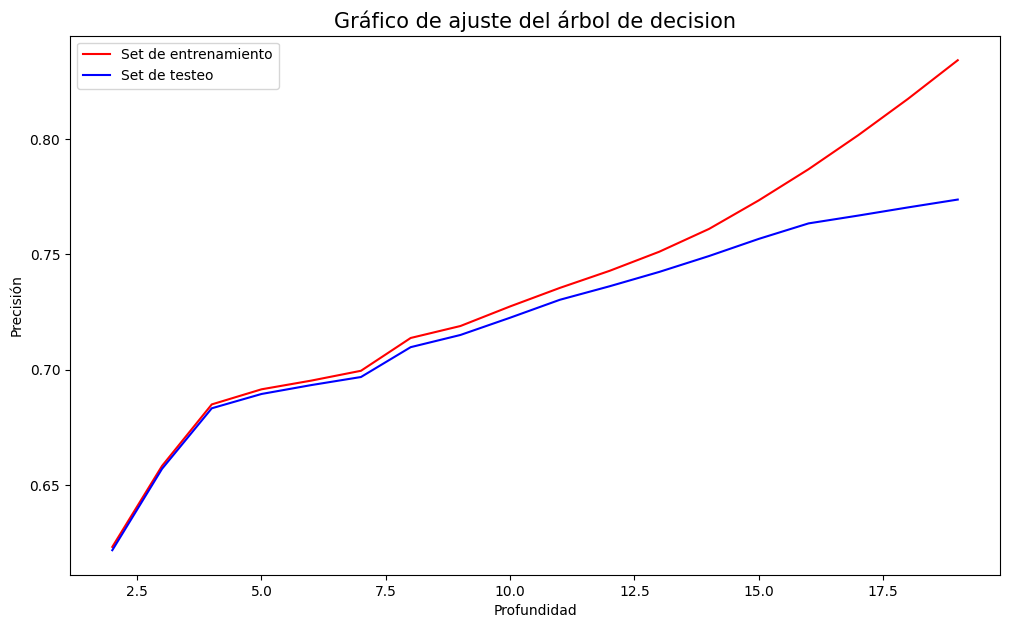

In [11]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(2, 20))

for deep in max_deep_list:
    clf_3 = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf_3.fit(X_Train, Y_Train)
    train_prec.append(clf_3.score(X_Train, Y_Train))
    eval_prec.append(clf_3.score(X_Test, Y_Test))

plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

Se entrena el modelo.

In [12]:
# Se observa, según el gráfico anterior, que a una profundidad entre 12 y 13 empieza a disminuir la presicion del set de testeo.

dtc_model = DecisionTreeClassifier(max_depth=13, criterion='entropy', random_state=42)
dtc_model.fit(X_Train, Y_Train)
Y_Pred = dtc_model.predict(X_Test)

Se gráfica los valores de testeo y los valores predichos con una matriz de confusión.

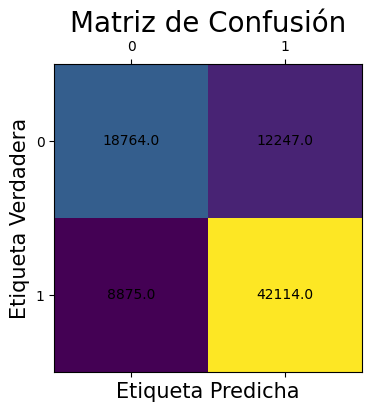

In [13]:
cm = confusion_matrix(Y_Test, Y_Pred)

fig, ax = plt.subplots(figsize=(8,4))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

Se observa los scores del modelo.

In [14]:
print(classification_report(Y_Test, Y_Pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64     31011
           1       0.77      0.83      0.80     50989

    accuracy                           0.74     82000
   macro avg       0.73      0.72      0.72     82000
weighted avg       0.74      0.74      0.74     82000



Se carga el dataframe de la consigna del proyecto y se realizan las mismas transformaciones que al anterior.

In [15]:
# Se usan las variables 'categorica' y 'numerica' que almacenan las mismas columnas del dataframe del modelo entrenado.
data2 = pd.read_csv('./datasets/hospitalizaciones_test.csv')
eval = transform(data2, to_le=categorica, to_ss=numerica)

Se predice y se crea un archivo csv con las prediciones.

In [16]:
predition = pd.DataFrame(dtc_model.predict(eval), columns=['pred'])
predition.to_csv('JoseAcevedo6', index=False)